# Train TCVAE
This notebook trains a new model and saves various artifacts, such as model architecture, model weights, animations, and plots to an experiment directory in `/experiments/`.

In [1]:
import os
import sys
import argparse as ap

import git
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, CSVLogger)

sys.path.append(git.Repo(search_parent_directories=True).working_dir)

from tcvae.models import TCVAE
from tcvae.models.square_128 import (
    make_encoder_7_convs, make_decoder_7_deconvs)
from tcvae.losses import convert_loss_dict_keys
from tcvae.data import ImageDataGenerator, crop_center_square
from tcvae.data.augmentation import *
from tcvae.utils import read_yaml, write_json, make_directory
from tcvae.callbacks import (
    ReconstructionCheck, LatentTraversalCheck, LatentDistributionLogging)
from tcvae.visualization import plot_img
# plot_loss_history, plot_dist_history

from config import EXPERIMENTS_DIR, YAML_DIR, TRAIN_DATA_DIR

%load_ext autoreload
%autoreload 2

/home/jovyan/my-conda-envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/my-conda-envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/my-conda-envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/my-conda-envs/tcvae/lib/python3.7/site-

# Parameters
- **Saving parameters** determine what artifacts are saved and where
- **Model hyperparameters** determine model architecture
- **Training hyperparameters** determine how training proceeds
- **Logging parameters** determine what monitoring information is saved throughout training process

In [2]:
# Saving parameters
EXPERIMENT_NAME = 'test'
OVERWRITE = False

# Training hyperparameters
N_EPOCHS = 1000
BATCH_SIZE = 256

# Logging parameters
N_DIST_LOG_IMGS = 1024
N_RECON_CHECK_IMGS = 8
N_VAL_IMGS = 1024

# Setup paths

In [3]:
experiment_dir = EXPERIMENTS_DIR / EXPERIMENT_NAME
experiment_dir.mkdir(exist_ok=True, parents=True)

training_dir = experiment_dir / 'training'
training_dir.mkdir(exist_ok=True, parents=True)

recon_check_dir = training_dir / 'reconstruction-check'
recon_check_dir.mkdir(exist_ok=True, parents=True)

traversal_check_dir = training_dir / 'traversal-check'
traversal_check_dir.mkdir(exist_ok=True, parents=True)

model_dir = training_dir / 'model'

latent_dist_history_log_file = \
    training_dir / 'latent-distribution-history.csv'
loss_history_log_file = training_dir / 'loss-history.csv'

# Load data generators
The training data generator applies random data augmentation transformations while the validation data generator does not. We use the following image data augmentation techniques:
- **RandomColorMixer**: applies random moderate contrast stretching and brightness shifting to each color channel independently. This causes image temperature and tints to change.
- **RandomIntensifier**: applies random contrast stretching and brightness shifting to entire image. This creates variations in contrast and brightness.
- **RandomFlipper**: randomly flips the image along its horizontal axis.
- **RandomSquareCropper**: crops the image to a randomly located and sized square.
- **RandomRotator**: randomly rotates the image about the center.

The order in which the augmentors are passed into the data generator matters. That is, `[f, g, h] implies f(g(h(x)))`.

In [4]:
augmentors = [
    RandomColorMixer(), RandomIntensifier(), RandomFlipper(),
    RandomSquareCropper(), RandomRotator()]
train_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=augmentors)
print(train_datagen, end='\n\n')

val_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=[crop_center_square])
print(val_datagen)

Image Data Generator
--------------------
Data path: /home/jovyan/tcvae/data/train
Number of files: 202599
Parallelization: 8

Image Data Generator
--------------------
Data path: /home/jovyan/tcvae/data/train
Number of files: 202599
Parallelization: 8


Let's take a peek at what augmented images look like.

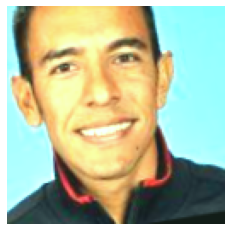

In [5]:
sample_train_img = train_datagen.load_n_images(1)[0]
plot_img(sample_train_img)

Let's sample out some images to use for checking reconstruction and traversal quality as the model trains.

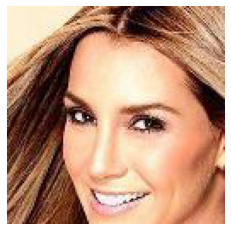

In [6]:
recon_check_imgs = val_datagen.load_n_images(N_RECON_CHECK_IMGS, random=False)
traversal_check_img = val_datagen.load_n_images(1, random=False).squeeze()
plot_img(traversal_check_img)

To log the means and variances of latent distributions, we'll want a larger number of sample images from the training set (since latent components may cover some of the axes of variation introduced through data augmentation).

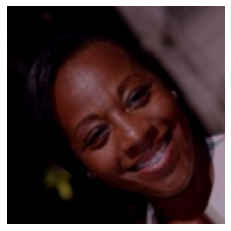

In [7]:
dist_log_imgs = train_datagen.load_n_images(1024, random=True)
plot_img(dist_log_imgs[0])

# Define callbacks

In [8]:
reconstruction_checker = ReconstructionCheck(
    recon_check_imgs, recon_check_dir)
traversal_checker = LatentTraversalCheck(
    traversal_check_img, traversal_check_dir)
dist_logger = LatentDistributionLogging(
    latent_dist_history_log_file, dist_log_imgs, verbose=True)
nan_terminator = TerminateOnNaN()
csv_logger = CSVLogger(loss_history_log_file.as_posix(), append=True)
lr_reducer = ReduceLROnPlateau(
    verbose=2, monitor='loss', factor=0.5, patience=3, min_delta=0, min_lr=1e-7)
early_stopper = EarlyStopping(
    verbose=2, restore_best_weights=True, monitor='loss', patience=10)
callbacks = [
    reconstruction_checker, traversal_checker, dist_logger,
    nan_terminator, csv_logger, lr_reducer, early_stopper]

# Define model

In [12]:
K.clear_session()
loss_dict = dict(
    total_correlation=64,
    sigmoid_cross_entropy=0.5,
    dssim=0.5,
    mutual_information_index=0.,
    dimensional_kl=1.)
loss_dict = convert_loss_dict_keys(loss_dict)
encoder = make_encoder_7_convs(
    activation='elu', num_latents=64, batch_normalization=False)
decoder = make_decoder_7_deconvs(
    activation='elu', num_latents=64, batch_normalization=False)
model = TCVAE(
    encoder, decoder, loss_dict, batch_size=train_datagen.batch_size,
    dataset_size=train_datagen.n_samples)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer)

total_correlation: 64
sigmoid_cross_entropy: 0.5
dssim: 0.5
mutual_information_index: 0.0
dimensional_kl: 1.0


# Train model

In [ ]:
# Keras model needs jump-starting for some reason
train_sample = train_datagen.load_n_images(1024)
model.fit(train_sample, train_sample, batch_size=BATCH_SIZE)

model.fit_generator(
    train_datagen, callbacks=callbacks, epochs=N_EPOCHS)

1024/1024 [==============================] - 3s 3ms/sample - loss: 36340.8438 - total_correlation: 1.3693 - sigmoid_cross_entropy: 34059.3711 - dssim: 38406.8984 - mutual_information_index: 0.8126 - dimensional_kl: 20.0693
Epoch 1/1000
791/792 [============================>.] - ETA: 1s - loss: 24539.8297 - total_correlation: 28.4112 - sigmoid_cross_entropy: 26360.3516 - dssim: 19040.0488 - mutual_information_index: 5.3340 - dimensional_kl: 21.3048Latent sigmas epoch:
[0.7739293  0.34571758 0.52211934 0.41838607 0.4642207  0.44687632
 0.80673677 0.41582316 0.35929802 0.55561614 0.78873485 0.7668611
 0.49813086 0.76177585 0.61087906 0.5805343  0.619341   0.70841515
 0.5385078  0.75033295 0.69638443 0.8012675  0.42348027 0.638468
 0.38377303 0.66695845 0.82397795 0.64474183 0.5653616  0.7990635
 0.8021592  0.7969269  0.81025577 0.62282664 0.81394744 0.5882468
 0.4362241  0.74349165 0.8311883  0.82196254 0.7120891  0.26016957
 0.3470656  0.8289765  0.404135   0.76594764 0.5028196  0.525074

In [11]:
model.save(model_dir)